# Fine Tuning

## Requirements

In [22]:
import torch

import pandas as pd
import matplotlib.pyplot as plt

from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, BitsAndBytesConfig
from datasets import load_dataset, load_from_disk, concatenate_datasets
from peft import LoraConfig, TaskType, get_peft_model
from peft.utils import prepare_model_for_kbit_training
from data_collator import CustomDataCollator
from sklearn.model_selection import train_test_split

SEED = 12345

## Configure and Load Original Model

In [23]:
# Definitions
MODEL_ID = "meta-llama/Meta-Llama-3.1-8B-Instruct"
TOKEN = "<ANONYMIZED>"

In [24]:
# Hugging faces login for gated models
login(TOKEN)

In [25]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

In [26]:
# Configuring o BitsAndBytes
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16"
)

In [6]:
# Loading model to VRAM
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=quant_config,
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Dataset Preprocessing

### N1

In [3]:
# Dataset read
dataset = load_dataset("csv", data_files="./Datasets/06_SampledBalancedDataset.csv")['train']
dataset

Dataset({
    features: ['DINAMICA', 'N1', 'N2', 'N3'],
    num_rows: 186549
})

In [18]:
# N1 Train test split
train_indices, eval_indices = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    stratify=dataset['N1'],
    random_state=SEED
)

train_dataset_N1 = dataset.select(train_indices)
eval_dataset_N1 = dataset.select(eval_indices)

display(train_dataset_N1)
display(eval_dataset_N1)

Dataset({
    features: ['DINAMICA', 'N1', 'N2', 'N3'],
    num_rows: 149239
})

Dataset({
    features: ['DINAMICA', 'N1', 'N2', 'N3'],
    num_rows: 37310
})

In [27]:
def format_prompt(row, classes=None):
    # Construct separated prompt and answer
    prompt = (
        f"Responda a instrução a seguir em formato JSON.\n"
        'Exemplo de resposta:\n{\n"delito": "..."\n}\n\n'
        f"Classifique a seguinte narrativa em um dos tipos de delitos providos a seguir:\n\n"
        f"NARRATIVA: {row['DINAMICA']}\n\n"
        f"TIPOS DE DELITOS:\n{classes}\n\n"
        f"A sua resposta deve ser em formato JSON com um campo chamado 'delito' com o valor da classificação.\n\n"
        f'Resposta: '
    )

    answer = f'{{"delito": "{row["N1"]}"}}'

    # Separated tokenization
    prompt_tokens = tokenizer(prompt, add_special_tokens=False)
    answer_tokens = tokenizer(answer, add_special_tokens=False)

    # Concatenate input_ids and attention_mask
    input_ids = prompt_tokens["input_ids"] + answer_tokens["input_ids"]
    attention_mask = prompt_tokens["attention_mask"] + answer_tokens["attention_mask"]

    # Create labels: -100 for prompt, real ids for answers
    labels = [-100] * len(prompt_tokens["input_ids"]) + answer_tokens["input_ids"]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# Formating train and test prompts
classes = list(set(dataset['N1']))
tokenized_train_dataset_N1 = train_dataset_N1.map(format_prompt, remove_columns=dataset.column_names, fn_kwargs={"classes": classes}, num_proc=30, load_from_cache_file=False)
tokenized_eval_dataset_N1 = eval_dataset_N1.map(format_prompt, remove_columns=dataset.column_names, fn_kwargs={"classes": classes}, num_proc=30, load_from_cache_file=False)

display(tokenized_train_dataset_N1)
display(tokenized_eval_dataset_N1)

Map (num_proc=30):   0%|          | 0/149239 [00:00<?, ? examples/s]

Map (num_proc=30):   0%|          | 0/37310 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 149239
})

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 37310
})

### N2

In [28]:
# Loading classification tree
dm = pd.read_csv('./Datasets/04_DomainHierarchy.csv')

In [29]:
# N2 Train test split
train_datasets = []
eval_datasets = []
for label in set(dataset['N1']):
    subset = dataset.filter(lambda row: row['N1'] == label)

    train_indices, eval_indices = train_test_split(
        list(range(len(subset))),
        test_size=0.2,
        stratify=subset['N2'],
        random_state=SEED
    )

    train_datasets.append(subset.select(train_indices))
    eval_datasets.append(subset.select(eval_indices))

train_dataset_N2 = concatenate_datasets(train_datasets)
eval_dataset_N2 = concatenate_datasets(eval_datasets)
display(train_dataset_N2)
display(eval_dataset_N2)

Dataset({
    features: ['DINAMICA', 'N1', 'N2', 'N3'],
    num_rows: 149236
})

Dataset({
    features: ['DINAMICA', 'N1', 'N2', 'N3'],
    num_rows: 37313
})

In [30]:
def format_prompt(row, classes=None):
    classes = dm[dm['N1'] == row['N1']]['N2'].unique()
    
    prompt = (
        f"Responda a instrução a seguir em formato JSON.\n"
        'Exemplo de resposta:\n{\n"delito": "..."\n}\n\n'
        f"Classifique a seguinte narrativa em um dos tipos de delitos providos a seguir:\n\n"
        f"NARRATIVA: {row['DINAMICA']}\n\n"
        f"TIPOS DE DELITOS:\n{classes}\n\n"
        f"A sua resposta deve ser em formato JSON com um campo chamado 'delito' com o valor da classificação.\n\n"
        f'Resposta: '
    )

    answer = f'{{"delito": "{row["N2"]}"}}'

    # Separated tokenization
    prompt_tokens = tokenizer(prompt, add_special_tokens=False)
    answer_tokens = tokenizer(answer, add_special_tokens=False)

    # Concatenate input_ids and attention_mask
    input_ids = prompt_tokens["input_ids"] + answer_tokens["input_ids"]
    attention_mask = prompt_tokens["attention_mask"] + answer_tokens["attention_mask"]

    # Create labels: -100 for prompt, real ids fro answers
    labels = [-100] * len(prompt_tokens["input_ids"]) + answer_tokens["input_ids"]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# Formating train and test prompts
tokenized_train_dataset_N2 = train_dataset_N2.map(format_prompt, remove_columns=dataset.column_names, num_proc=30, load_from_cache_file=False)
tokenized_eval_dataset_N2 = eval_dataset_N2.map(format_prompt, remove_columns=dataset.column_names, num_proc=30, load_from_cache_file=False)
display(tokenized_train_dataset_N2)
display(tokenized_eval_dataset_N2)

Map (num_proc=30):   0%|          | 0/149236 [00:00<?, ? examples/s]

Map (num_proc=30):   0%|          | 0/37313 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 149236
})

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 37313
})

### N3

In [31]:
# N3 Train test split
train_datasets = []
eval_datasets = []
for label in set(dataset['N2']):
    subset = dataset.filter(lambda row: row['N2'] == label)

    train_indices, eval_indices = train_test_split(
        list(range(len(subset))),
        test_size=0.2,
        stratify=subset['N3'],
        random_state=SEED
    )

    train_datasets.append(subset.select(train_indices))
    eval_datasets.append(subset.select(eval_indices))

train_dataset_N3 = concatenate_datasets(train_datasets)
eval_dataset_N3 = concatenate_datasets(eval_datasets)
display(train_dataset_N3)
display(eval_dataset_N3)

Dataset({
    features: ['DINAMICA', 'N1', 'N2', 'N3'],
    num_rows: 149229
})

Dataset({
    features: ['DINAMICA', 'N1', 'N2', 'N3'],
    num_rows: 37320
})

In [32]:
def format_prompt(row, classes=None):
    classes = dm[dm['N2'] == row['N2']]['N3'].unique()
    
    prompt = (
        f"Responda a instrução a seguir em formato JSON.\n"
        'Exemplo de resposta:\n{\n"delito": "..."\n}\n\n'
        f"Classifique a seguinte narrativa em um dos tipos de delitos providos a seguir:\n\n"
        f"NARRATIVA: {row['DINAMICA']}\n\n"
        f"TIPOS DE DELITOS:\n{classes}\n\n"
        f"A sua resposta deve ser em formato JSON com um campo chamado 'delito' com o valor da classificação.\n\n"
        f'Resposta: '
    )

    answer = f'{{"delito": "{row["N3"]}"}}'

    # Separated tokenization
    prompt_tokens = tokenizer(prompt, add_special_tokens=False)
    answer_tokens = tokenizer(answer, add_special_tokens=False)

    # Concatenate input_ids and attention_mask
    input_ids = prompt_tokens["input_ids"] + answer_tokens["input_ids"]
    attention_mask = prompt_tokens["attention_mask"] + answer_tokens["attention_mask"]

    # Create labels: -100 for prompt, real ids fro answers
    labels = [-100] * len(prompt_tokens["input_ids"]) + answer_tokens["input_ids"]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# Formating train and test prompts
tokenized_train_dataset_N3 = train_dataset_N3.map(format_prompt, remove_columns=dataset.column_names, num_proc=30, load_from_cache_file=False)
tokenized_eval_dataset_N3 = eval_dataset_N3.map(format_prompt, remove_columns=dataset.column_names, num_proc=30, load_from_cache_file=False)
display(tokenized_train_dataset_N3)
display(tokenized_eval_dataset_N3)

Map (num_proc=30):   0%|          | 0/149229 [00:00<?, ? examples/s]

Map (num_proc=30):   0%|          | 0/37320 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 149229
})

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 37320
})

### Concatenating, Splitting and Saving

In [33]:
# Splitting the datasets into training and validation
train_dataset = concatenate_datasets([
    tokenized_train_dataset_N1,
    tokenized_train_dataset_N2,
    tokenized_train_dataset_N3,
]).shuffle(seed=SEED)

eval_dataset = concatenate_datasets([
    tokenized_eval_dataset_N1,
    tokenized_eval_dataset_N2,
    tokenized_eval_dataset_N3,
]).shuffle(seed=SEED)

display(train_dataset)
display(eval_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 447704
})

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 111943
})

In [34]:
# Saving
train_dataset.save_to_disk("./Datasets/08_TrainDataset")
eval_dataset.save_to_disk("./Datasets/09_EvalDataset")

Saving the dataset (0/6 shards):   0%|          | 0/447704 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/111943 [00:00<?, ? examples/s]

## Configure Model Fine Tuning

In [7]:
# Configuring LoRA
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"] 
)

In [8]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

## Configure Training And Train Model

In [9]:
train_dataset = load_from_disk("./Datasets/08_TrainDataset")
eval_dataset = load_from_disk("./Datasets/09_EvalDataset")
display(train_dataset)
display(eval_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 447717
})

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 111930
})

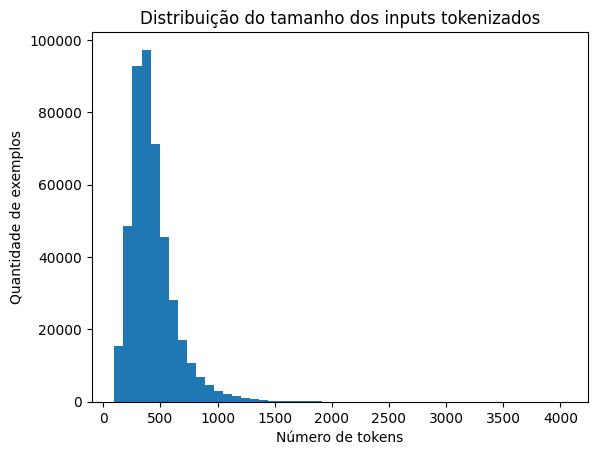

85.54% dos inputs têm mais que 256 tokens


In [11]:
# input lengths distribution
input_lens = [len(x) for x in train_dataset['input_ids']]

plt.hist(input_lens, bins=50)
plt.xlabel("Número de tokens")
plt.ylabel("Quantidade de exemplos")
plt.title("Distribuição do tamanho dos inputs tokenizados")
plt.show()

# Mostra percentual de inputs maiores que 256 tokens
largos = sum(l > 256 for l in input_lens)
total = len(input_lens)
print(f"{largos/total*100:.2f}% of inputs has more than 256 tokens")

In [9]:
# Configuring training arguments
training_args = TrainingArguments(
    output_dir="./finetuned_model",
    num_train_epochs=2,

    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=1,
    eval_accumulation_steps=4,
    
    gradient_checkpointing=True,
    
    eval_strategy="epoch",
    logging_strategy="epoch",
    
    logging_first_step=True,
    logging_dir="./logs",
    
    learning_rate=1e-4,
    save_steps=100,
    save_total_limit=2,

    fp16=True,
    label_names=["labels"],
    
    dataloader_num_workers=4,
    deepspeed="./deepspeed_config.json",
)

In [10]:
data_collator = CustomDataCollator(tokenizer=tokenizer)

In [12]:
# Trainer configuration and train
# The processing was stopped and executed by a script because it needs to keep running for 14 days
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
   
)
model.config.use_cache = False
trainer.train()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Save models
trainer.save_model("./finetuned_model")
tokenizer.save_pretrained("./finetuned_model")